In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import os
import pickle
import sys
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [2]:

# Add parent directory to path to import utilities
sys.path.append('..')
from src.model import WeatherClassifier

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained model
model_path = '../models/weather_classifier.pth'
classifier = WeatherClassifier()
classifier.load_model(model_path)

# Load training history
history_path = '../models/training_history.pkl'

Using device: cpu


c:\Users\chomm\anaconda3\envs\bank-churn\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chomm\anaconda3\envs\bank-churn\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded with classes: ['lightning', 'rainbow', 'sandstorm', 'snow']


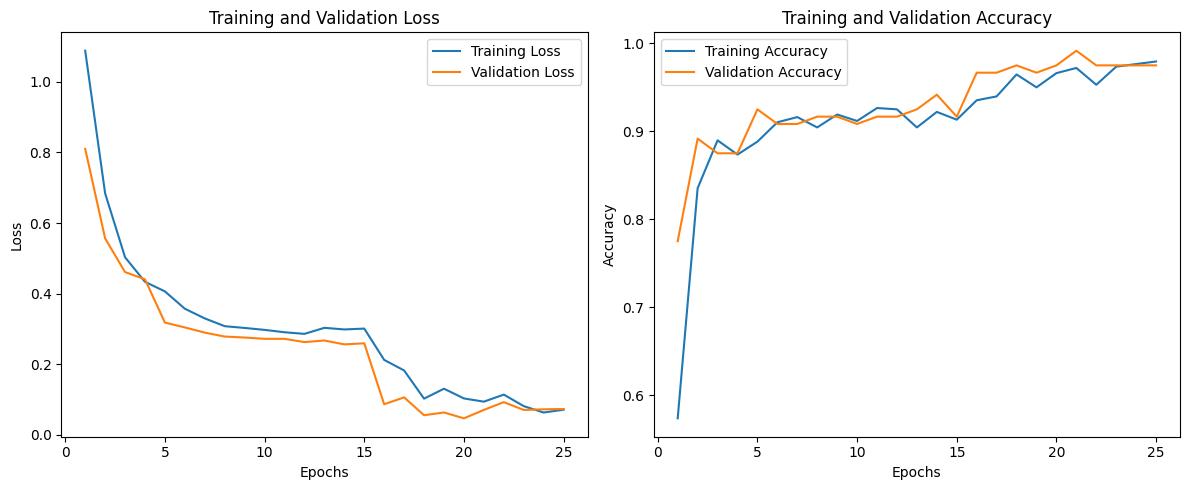

In [3]:
try:
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history['train_losses']) + 1), history['train_losses'], label='Training Loss')
    plt.plot(range(1, len(history['val_losses']) + 1), history['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history['train_accs']) + 1), history['train_accs'], label='Training Accuracy')
    plt.plot(range(1, len(history['val_accs']) + 1), history['val_accs'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('../models/training_history_plot.png')
    plt.show()
except Exception as e:
    print(f"Could not load training history: {e}")

# Data transforms for evaluation
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load test dataset
data_dir = '../data'
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)



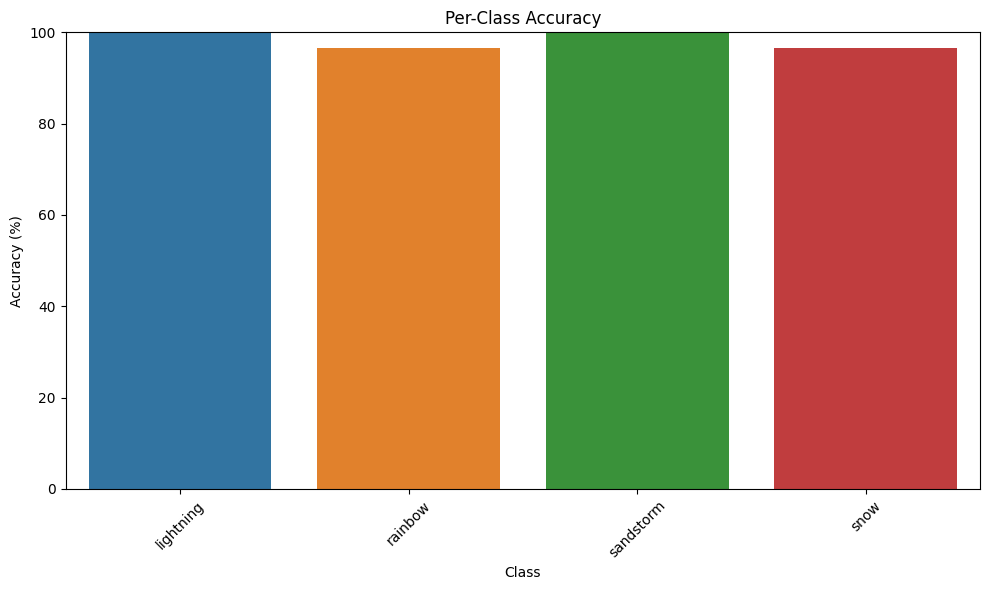


Per-class Accuracy:
lightning: 100.00%
rainbow: 96.67%
sandstorm: 100.00%
snow: 96.67%


In [4]:
class_names = classifier.class_names

# Per-class accuracy
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = classifier.model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
class_accuracies = [100 * class_correct[i] / class_total[i] for i in range(len(class_names))]
sns.barplot(x=class_names, y=class_accuracies)
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Class')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../models/per_class_accuracy.png')
plt.show()

print("\nPer-class Accuracy:")
for i in range(len(class_names)):
    print(f"{class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")

In [5]:
# Evaluate the model
def evaluate_model(model, dataloader):
    model.model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model.model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

# Get test accuracy
test_accuracy, all_preds, all_labels = evaluate_model(classifier, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.33%


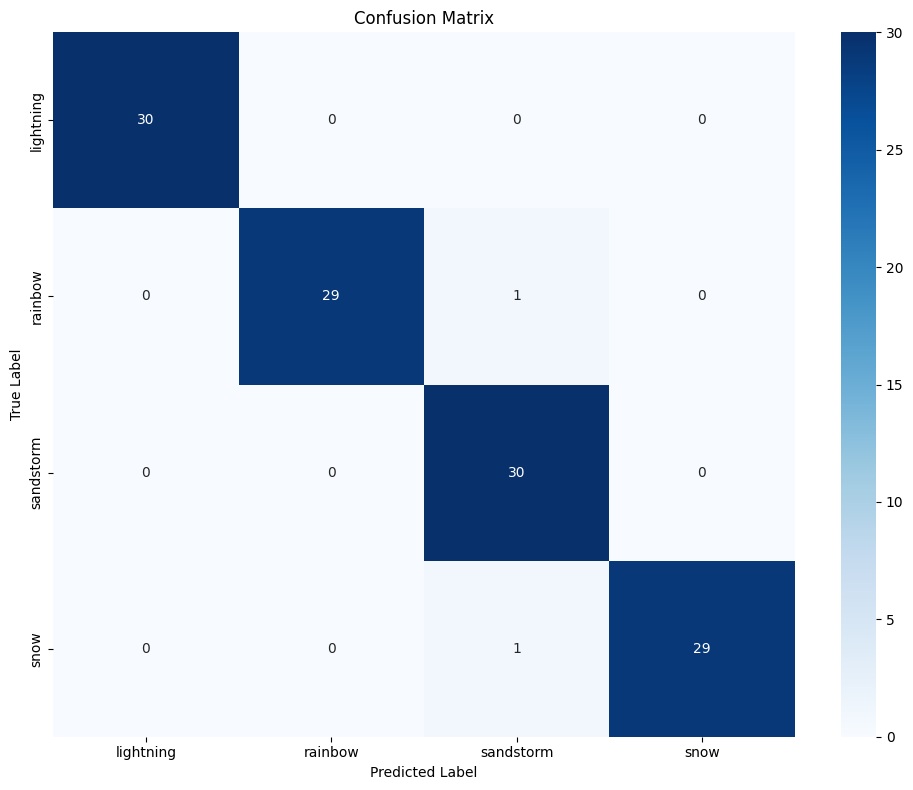


Classification Report:
              precision    recall  f1-score   support

   lightning       1.00      1.00      1.00        30
     rainbow       1.00      0.97      0.98        30
   sandstorm       0.94      1.00      0.97        30
        snow       1.00      0.97      0.98        30

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [6]:

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = classifier.class_names

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

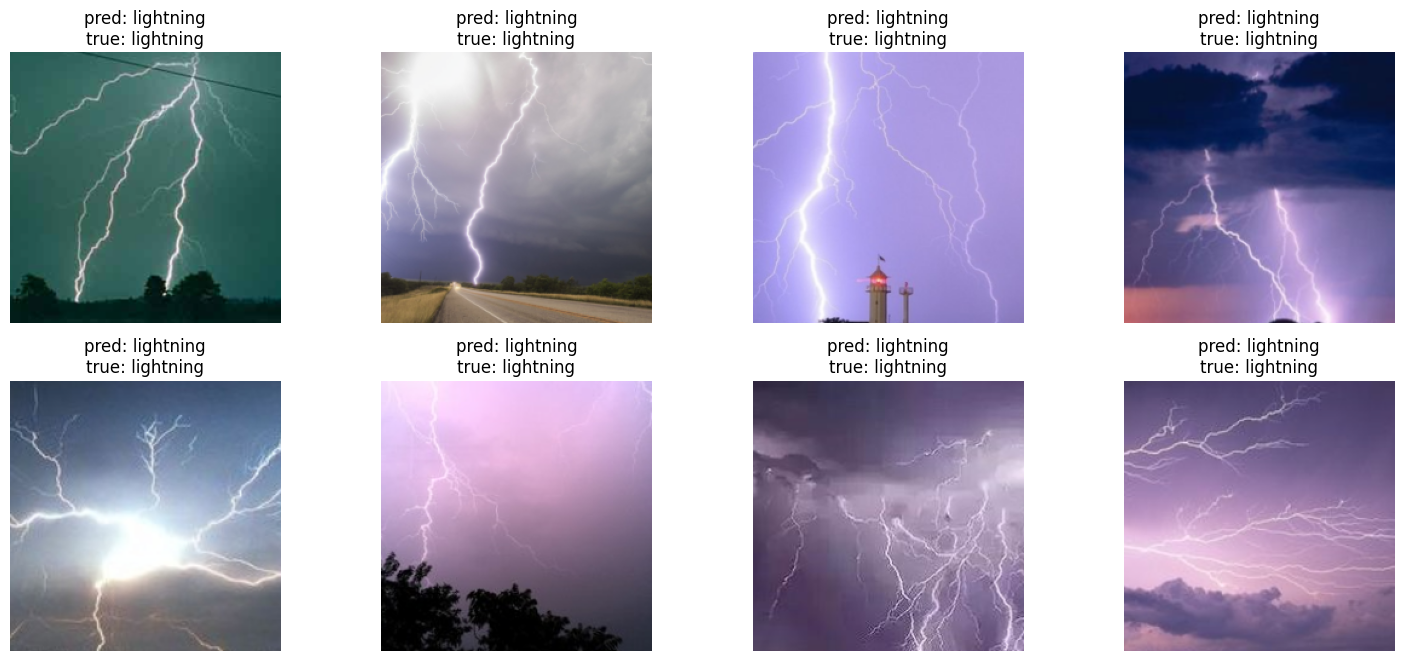

In [7]:
# Visualize some predictions
def visualize_predictions(model, dataloader, num_images=8):
    model.model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model.model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4 + 1, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}')
                
                # Convert tensor to numpy for display
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.savefig('../models/test_predictions.png')
                    plt.show()
                    return
    
    plt.tight_layout()
    plt.savefig('../models/test_predictions.png')
    plt.show()

# Visualize some test predictions
visualize_predictions(classifier, test_loader)


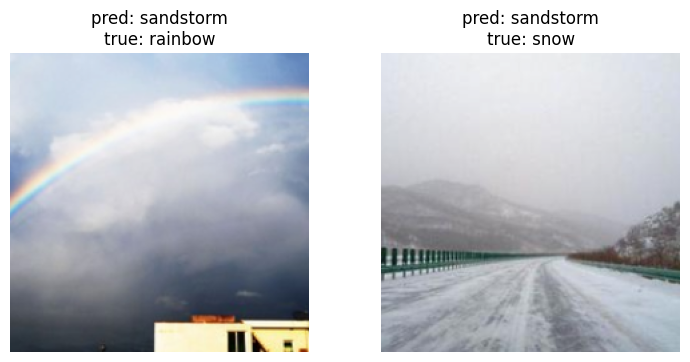


Evaluation complete!


In [8]:
# Check for misclassifications
def show_misclassifications(model, dataloader, num_images=8):
    model.model.eval()
    misclassified_inputs = []
    misclassified_preds = []
    misclassified_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model.model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Find misclassified images
            for j in range(inputs.size()[0]):
                if preds[j] != labels[j]:
                    misclassified_inputs.append(inputs.cpu().data[j])
                    misclassified_preds.append(preds[j].item())
                    misclassified_labels.append(labels[j].item())
                    
                    if len(misclassified_inputs) >= num_images:
                        break
            
            if len(misclassified_inputs) >= num_images:
                break
    
    # Display misclassified images
    if misclassified_inputs:
        fig = plt.figure(figsize=(15, 10))
        for i in range(len(misclassified_inputs)):
            ax = plt.subplot(num_images//4 + 1, 4, i + 1)
            ax.axis('off')
            ax.set_title(f'pred: {class_names[misclassified_preds[i]]}\ntrue: {class_names[misclassified_labels[i]]}')
            
            # Convert tensor to numpy for display
            inp = misclassified_inputs[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            ax.imshow(inp)
        
        plt.tight_layout()
        plt.savefig('../models/misclassified_examples.png')
        plt.show()
    else:
        print("No misclassifications found in the sample.")

# Show misclassified examples
show_misclassifications(classifier, test_loader)

print("\nEvaluation complete!")